In [1]:
import pennylane as qml
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_spec_table import *
import matplotlib.pyplot as plt
import time
from qiskit.transpiler import PassManager

In [2]:
[ds] = qml.data.load("ketgpt")

In [3]:
# example
seed = 1
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

time_q = []
time_p = []
time_m = []

# q_template
qc = to_qc(circuit)
pm = PassManager()
pm.append([TemplateOptimization()])
start = time.time()
transpiled_qiskit = pm.run(qc)
end = time.time()
print(end-start)

# q
pm = PassManager()
self_inverse_gates = [XGate(), YGate(), ZGate(), HGate(), 
                CXGate(), CYGate(), CZGate(), SwapGate()]
pm.append([InverseCancellation(gates_to_cancel=self_inverse_gates), Optimize1qGates(), Collect2qBlocks()])
start = time.time()
transpiled_qiskit = pm.run(qc)
end = time.time()
print(end-start)

# p 
pipeline = [cancel_inverses, merge_rotations]
start = time.time()
transpiled_penny = compile(circuit, pipeline=pipeline)
end = time.time()
print(end-start)

# m
start = time.time()
qnode_q2 = optimization_level_2(circuit)
qnode_q1 = optimization_level_1(qnode_q2)
qnode_q2 = optimization_level_2(qnode_q1)
end = time.time()
print(end-start)

[380, 232, 148, 73, 5]
1.932067632675171
0.0
0.0
0.30088043212890625


In [ ]:
time_q = []
time_q_template = []
time_p = []
time_m = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        # q_template
        qc = to_qc(circuit)
        pm = PassManager()
        pm.append([TemplateOptimization()])
        start = time.time()
        transpiled_qiskit = pm.run(qc)
        end = time.time()
        time_q.append(end-start)

        # q
        pm = PassManager()
        self_inverse_gates = [XGate(), YGate(), ZGate(), HGate(), 
                        CXGate(), CYGate(), CZGate(), SwapGate()]
        pm.append([InverseCancellation(gates_to_cancel=self_inverse_gates), Optimize1qGates(), Collect2qBlocks()])
        start = time.time()
        transpiled_qiskit = pm.run(qc)
        end = time.time()
        time_q_template.append(end-start)

        # p 
        pipeline = [cancel_inverses, merge_rotations]
        start = time.time()
        transpiled_penny = compile(circuit, pipeline=pipeline)
        end = time.time()
        time_p.append(end-start)

        # m
        start = time.time()
        qnode_q2 = optimization_level_2(circuit)
        qnode_q1 = optimization_level_1(qnode_q2)
        qnode_q2 = optimization_level_2(qnode_q1)
        end = time.time()
        time_m.append(end-start)
    except:
        pass

In [5]:
len(time_q)

1000

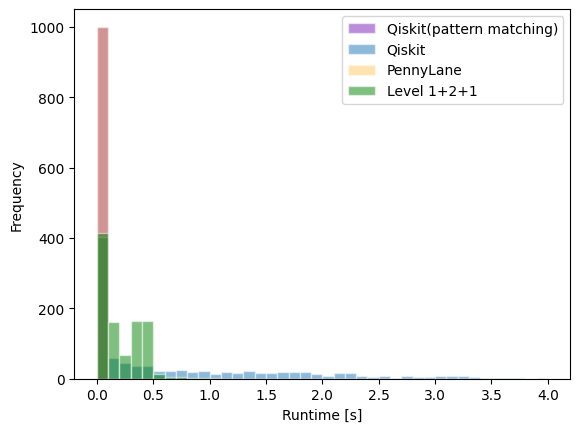

In [ ]:
plt.hist(time_q_template, bins=np.arange(0,4.1,0.1), edgecolor='white', color='#7b1fb4', alpha=0.5)
plt.hist(time_q, bins=np.arange(0,4.1,0.1), edgecolor='white', alpha=0.5)
plt.hist(time_p,  bins=np.arange(0,4.1,0.1), edgecolor='white', color='orange', alpha=0.3)
plt.hist(time_m, bins=np.arange(0,4.1,0.1), edgecolor='white', color='green', alpha=0.5)
# plt.xticks(np.arange(0,3.6,1))
plt.xlabel('Runtime [s]')
plt.ylabel('Frequency')
plt.legend(['Qiskit(pattern matching)', 'Qiskit', 'PennyLane', 'Level 2+1+2'])
plt.show()

In [20]:
print(np.mean(time_q_template), np.mean(time_q), np.mean(time_p), np.mean(time_m))

0.002064387798309326 1.1416250898838043 4.293394088745117e-05 0.21113590908050536


In [21]:
print(np.std(time_q_template), np.std(time_q), np.std(time_p), np.std(time_m))

0.004773748381004205 5.786061251246563 0.00070769879959171 0.18135562935260152
